<a href="https://colab.research.google.com/github/maadhuvijay/Project-3-AI-Bootcamp/blob/main/Lego_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LEGO Brick Classifier

In [197]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import pickle


from PIL import Image
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

In [198]:
!pip install gradio
!pip install pyttsx3
!sudo apt install espeak #Install espeak text-to-speech engine
!sudo apt install espeak-ng

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
espeak is already the newest version (1.48.15+dfsg-3).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
espeak-ng is already the newest version (1.50+dfsg-10ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


# Importing Data

In [199]:

# Upload a ZIP File and Extract
from google.colab import files
uploaded = files.upload()

Saving data_modify.zip to data_modify (1).zip


In [200]:

# Unzip the file

import zipfile
import imghdr

zip_file = "data_modify.zip"  # Change to your filename
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("/content/images")  # Extract to 'images' folder



In [277]:
#Load images


image_folder = "/content/images/data_modify"
images = []
file_names = []


# Load images only if they are valid image files
for filename in os.listdir(image_folder):
    file_path = os.path.join(image_folder, filename)


    # Check if the file is a valid image
    if os.path.isfile(file_path):
        # Check if the file is a valid image
        if imghdr.what(file_path):
            img = Image.open(file_path)  # Open the image using PIL

             #black back ground to white
            #image_array = np.array(img)
            #black_pixels = (image_array[:, :, :3] == 0).all(axis=-1)
            #image_array[black_pixels] = [255, 255, 255]
            #img = Image.fromarray(image_array)

            images.append(img)
            file_names.append({"filename": filename})
# Convert to DataFrame
#file_names=set(f["filename"] for f in file_names)
filename_df = pd.DataFrame(file_names, columns=['filename'])

# Display DataFrame
#filename_df.head(10)  # Show first few rows
print(f"Loaded {len(images)} images")




Loaded 1132 images


## Pickling the images

In [ ]:
"""
# Mount the images to the drive

drive.mount('/content/drive')

# Open a new file named 'img.pkl' with write permission
with open('/content/drive/My Drive/img.pkl', 'wb') as file:
    # Use pickle.dump to store the list of images
    pickle.dump(images, file)

    """

Mounted at /content/drive


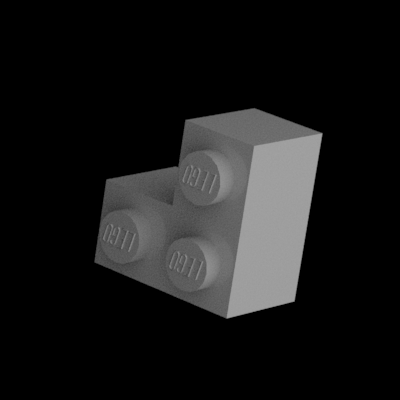

In [ ]:
"""
# Load the images from the pkl file
with open('/content/drive/My Drive/img.pkl', 'rb') as file:
    images = pickle.load(file)

images[800]

"""

In [278]:
from google.colab import drive
import pickle

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [279]:
from tensorflow.keras.models import load_model
# Re-load model
model1 = keras.models.load_model('/content/drive/MyDrive/model1_trained.keras')
#model2 = keras.models.load_model('/content/drive/MyDrive/model2.keras')
model3 = keras.models.load_model('/content/drive/MyDrive/model3_trained.keras')

# Extract the file names

In [202]:
"""

# Create a dataframe to store the file names from Images

file_names = []
# Walk through the directory and get all image filenames
for root, _, files in os.walk(image_folder):
    for filename in files:
        file_path = os.path.join(root, filename)

        # Append only image files
        if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
            file_names.append({"filename": filename})


# Convert to DataFrame
file_names=set(f["filename"] for f in file_names)
filename_df = pd.DataFrame(file_names, columns=['filename'])

# Display DataFrame
filename_df.head()  # Show first few rows

"""

,filename
0,2357 brick corner 1x2x2 140L.png
1,3010 brick 1x4 336R.png
2,3010 brick 1x4 333R.png
3,3001 brick 2x4 049L.png
4,3010 brick 1x4 342R.png


In [280]:
# Check the shape of the dataframe

print(filename_df.shape)

(1132, 1)


## Data visualization

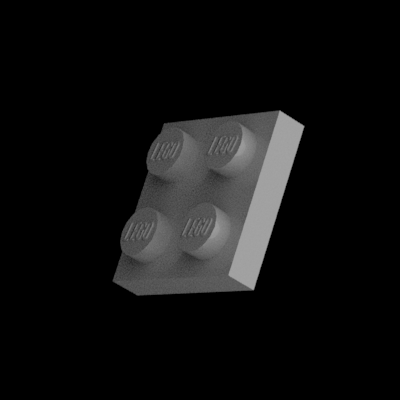

In [284]:
# Print a random image from the list to ensure the import was successful
images[810]

In [282]:
filename_df.iloc[806:,]

,filename
806,3010 brick 1x4 302R.png
807,2357 brick corner 1x2x2 003R.png
808,3010 brick 1x4 300R.png
809,3022 Plate 2x2 274R.png
810,3022 Plate 2x2 131L.png
...,...
1127,3001 brick 2x4 063L.png
1128,3022 Plate 2x2 332R.png
1129,3001 brick 2x4 330R.png
1130,3010 brick 1x4 187R.png


# Pre-processing Data

In [285]:
# Check the size of an image
images[400].size

(400, 400)

In [286]:
# Check the pixel values of images

print(np.array(images[400]).min(), np.array(images[400]).max())

0 152


In [287]:
# Get all the sizes into a list, then convert to a set
sizes = set([img.size for img in images])
sizes

{(400, 400)}

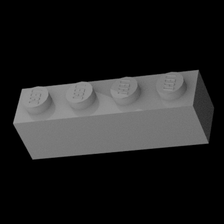

In [288]:
# Use a for loop to resize all images to 250 by 250
target_size = (224,224)

resized_images = [img.resize(target_size, resample = Image.LANCZOS) for img in images]
resized_images[806]

In [289]:
# Verify the resizing of all images
# Get all the sizes into a list, then convert to a set
sizes = set([img.size for img in resized_images])
sizes

{(224, 224)}

Batched Images Shape: (1132, 224, 224, 3)


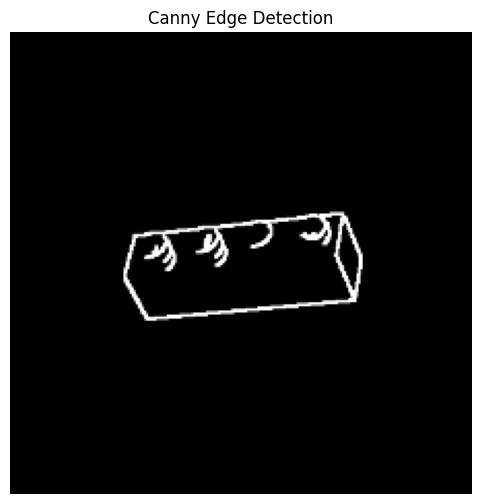

In [290]:

kernel = np.ones((3, 3), np.uint8)

new_images = [np.array(img)  for img in resized_images]
edges=[cv2.Canny(img,50,150) for img in new_images]

dilated_edges = [cv2.dilate(img, kernel, iterations=1) for img in edges]

#Padding

resized_images_input = [cv2.resize(img, (128, 128)) for img in dilated_edges]

  # Add padding to make it 224x224
top = bottom = (224 - 128) // 2
left = right = (224 - 128) // 2
resized_images_input = [np.array(img) for img in resized_images_input]
padded_images = [cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0) for img in resized_images_input]


expanded_edges = [np.stack((img,) * 3, axis=-1) for img in padded_images]
batched_images = np.array(expanded_edges)
print("Batched Images Shape:", batched_images.shape)  # Check the shape


plt.figure(figsize=(8,6))
plt.imshow(batched_images[806], cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")
plt.show()


In [291]:
# Convert to NumPy array and then to float32


float_images = [np.array(img).astype(np.float32) for img in batched_images]
print("Pixel Values:")
print(np.array(float_images[700]).min(), np.array(float_images[700]).max())


Pixel Values:
0.0 255.0


In [292]:
# Normalize pixel values to range [0, 1]
normalized_images = [img/255 for img in float_images]
print("Pixel Values:")
print(np.array(normalized_images[700]).min(), np.array(normalized_images[700]).max())


Pixel Values:
0.0 1.0


In [293]:
"""
# Invert the image for better feature extraction
inverted_images = [1 - img for img in normalized_images]
print(np.array(inverted_images[600]).min(), np.array(inverted_images[400]).max())
"""

'\n# Invert the image for better feature extraction\ninverted_images = [1 - img for img in normalized_images]\nprint(np.array(inverted_images[600]).min(), np.array(inverted_images[400]).max())\n'

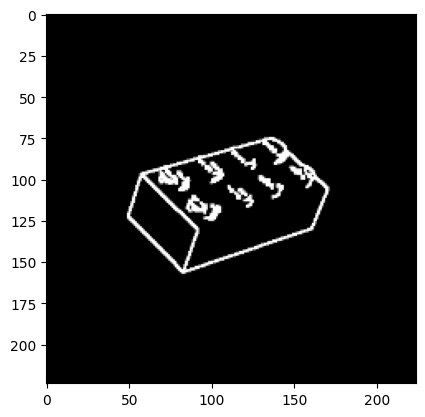

In [294]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(normalized_images[902])
plt.show()

In [295]:
#check the channel dimensions
normalized_images[400].shape

(224, 224, 3)

In [296]:
import tensorflow as tf

grayscale_images = tf.image.rgb_to_grayscale(normalized_images)


print(grayscale_images.shape)

(1132, 224, 224, 1)


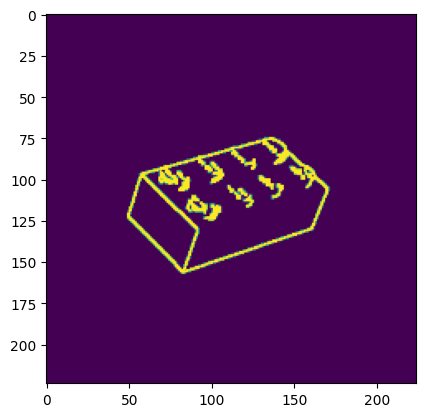

In [297]:
plt.imshow(grayscale_images[902])
plt.show()

In [298]:
#Check the pixels of gray scale images
print("Pixel Values:")
print(np.array(grayscale_images[500]).min(), np.array(grayscale_images[500]).max())


Pixel Values:
0.0 0.9999


# Labels

In [299]:
filename_df.head()

,filename
0,3001 brick 2x4 369L.png
1,3001 brick 2x4 122R.png
2,3001 brick 2x4 097R.png
3,3010 brick 1x4 279R.png
4,3001 brick 2x4 296R.png


In [300]:
# Function to handle different filename structures
def split_filename(filename):
    parts = filename.replace('.png', '').split()  # Remove .png if needed and split by space
    design_id = parts[0]  # First part is the design ID
    image_id = parts[-1]  # Last part is the image ID
    element_size = parts[-2]  # Second last part is the element size
    element_name = " ".join(parts[1:-2])  # Everything in between is the element name
    return pd.Series([design_id, element_name, element_size, image_id])


# Apply function to DataFrame
filename_df[['design_id', 'element_name', 'element_size', 'image_#']] = filename_df['filename'].apply(split_filename)


filename_df.head()

,filename,design_id,element_name,element_size,image_#
0,3001 brick 2x4 369L.png,3001,brick,2x4,369L
1,3001 brick 2x4 122R.png,3001,brick,2x4,122R
2,3001 brick 2x4 097R.png,3001,brick,2x4,097R
3,3010 brick 1x4 279R.png,3010,brick,1x4,279R
4,3001 brick 2x4 296R.png,3001,brick,2x4,296R


In [301]:
filename_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132 entries, 0 to 1131
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   filename      1132 non-null   object
 1   design_id     1132 non-null   object
 2   element_name  1132 non-null   object
 3   element_size  1132 non-null   object
 4   image_#       1132 non-null   object
dtypes: object(5)
memory usage: 44.3+ KB


In [302]:
# Now we can call our preprocessed pixel data 'X'
X = grayscale_images

# For our purposes, we'll select the design_id column as 'y'
y = filename_df['design_id']

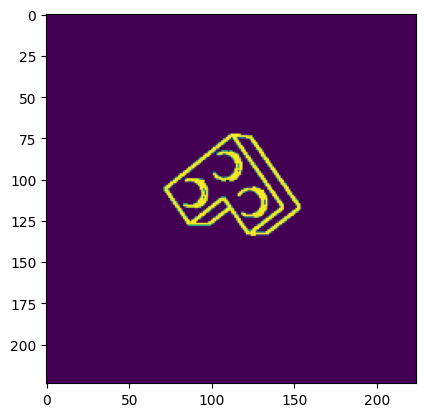

In [303]:
plt.imshow(X[100])

plt.show()

In [304]:
y[100]

'2357'

In [305]:
# Check the total number of classes
y.nunique()

4

In [306]:
# Get the actual class values
lego_classes = pd.Series(y).unique() # Convert y to a pandas Series
print(f"Lego Design Ids: {lego_classes}")

Lego Design Ids: ['3001' '3010' '3022' '2357']


In [307]:
y.shape

(1132,)

In [308]:
# Convert values to numpy arrays
X = np.array(X)
y = np.array(y)

In [309]:
X.shape, y.shape

((1132, 224, 224, 1), (1132,))

In [310]:
# Now we'll split our data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Checking if the length of training and testing data sets are same

In [311]:
# Print the length of each list
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

849
849
283
283


## Check if the image and labels match before augmentation

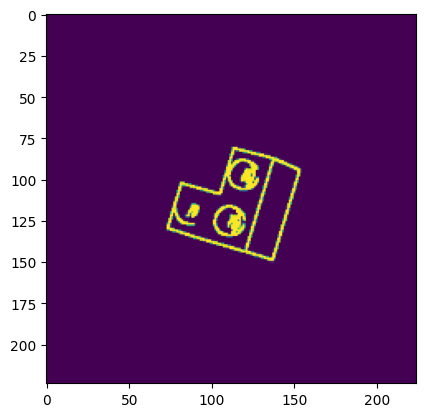

In [312]:
plt.imshow(X_train[100])

plt.show()

In [313]:
y_train[100]

'2357'

## Augmentation

In [314]:

# Apply augmentation to the whole training dataset

# Define the augmentation pipeline
data_augmentation = tf.keras.Sequential([

    tf.keras.layers.RandomFlip('horizontal'), # Random horizontal flip
    tf.keras.layers.RandomZoom(0.2),  # Random zoom (20%)
    tf.keras.layers.RandomFlip('vertical'),

])

# Create variables to hold the X and y training data
X_train_aug = []
y_train_aug = []

# Loop through all the images.
for i in range(len(X_train)):
      img = X_train[i]
      label = y_train[i]



    # Ensure that the input data has the correct shape
      img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Add 12 images for every original image
      for j in range(12):
          X_train_aug.append(data_augmentation(img, training=True)[0].numpy())
          y_train_aug.append(label)


# Print the length of each list
print(len(X_train_aug))
print(len(y_train_aug))



10188
10188


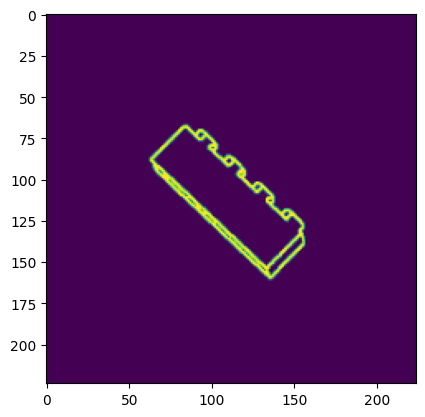

In [317]:
plt.imshow(X_train_aug[5])

plt.show()

In [318]:
y_train_aug[5]



'3010'

In [319]:


# Reshape test data for the model
X_test_np = []
for img in X_test:
  # Add a channel dimension for grayscale images

    X_test_np.append(img)

# Convert to numpy array
X_test_np = np.array(X_test_np)

# Check the shape of the first image
X_test_np[0].shape



(224, 224, 1)

# One hot Encoding of the target column

In [320]:
#One hot encode the y data

y_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(np.array(y_train_aug).reshape(-1, 1))
y_train_aug_enc = y_encoder.transform(np.array(y_train_aug).reshape(-1, 1))
y_test_enc = y_encoder.transform(np.array(y_test).reshape(-1, 1))


In [321]:
# Convert values to numpy arrays

#Augmentation code
X_train_aug_np = np.array(X_train_aug)
X_test_np = np.array(X_test_np)
y_train_aug_np = np.array(y_train_aug_enc)
y_test_np = np.array(y_test_enc)



## Check the shapes of augmented X and Y for batch dimensions

In [322]:
X_train_aug_np.shape

(10188, 224, 224, 1)

In [323]:
X_test_np.shape

(283, 224, 224, 1)

In [324]:
y_test_np.shape

(283, 4)

In [325]:
y_train_aug_np.shape

(10188, 4)

In [ ]:
#X_train_np = np.expand_dims(X_train_np[:, :, :, 0], axis=-1)
#X_test_np = np.expand_dims(X_test_np[:, :, :, 0], axis=-1)

In [326]:
# Split the training dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_aug_np, y_train_aug_np, test_size=0.3, random_state=42)

## Creating a CNN model

### Model1 - My current model

In [327]:
# Define a CNN model

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras import initializers


model1 = keras.Sequential([

    #Layer 1
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(224, 224, 1)),
    layers.MaxPooling2D((2, 2)),

    #Layer 2
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.0001)),
    layers.MaxPooling2D((2, 2)),

    #Layer 3
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.0001)),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    #Layer 4
    layers.Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0001)),
    layers.Dropout(0.3),

    #Layer 5
    layers.Dense(4, activation='softmax')
])



#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model

model1.compile(optimizer=Adam(learning_rate=0.00003), loss='categorical_crossentropy', metrics=['accuracy'])
#model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',AUC()])


# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=5,          # Number of epochs to wait for improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with the callback
history = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)
# Evaluate the model using the testing data
model1.evaluate(X_test_np, y_test_np)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


InternalError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-327-e370cd4c4276>", line 51, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

ptxas exited with non-zero error code 2, output: : If the error message indicates that a file could not be written, please verify that sufficient filesystem space is provided.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_7885255]

## Model1 Evaluation

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2742 - loss: 2.0617 

Test Accuracy: 25.80%
Test Loss: 2.0629


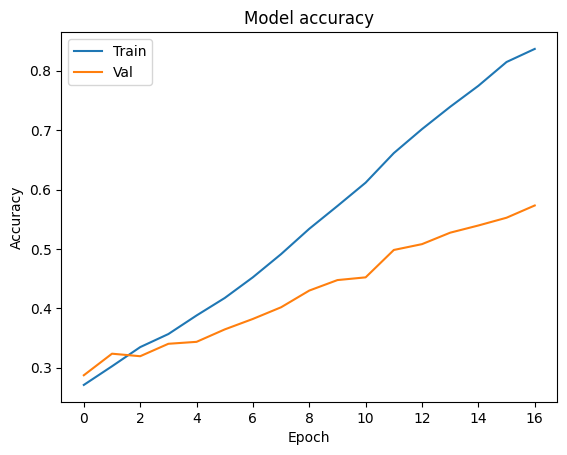

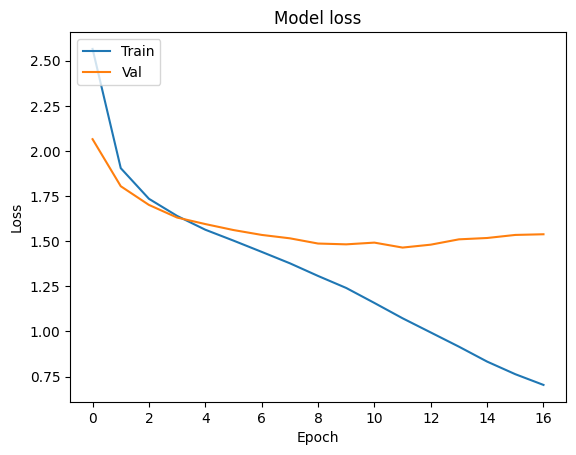

In [ ]:
# Evaluate the model using the testing data
test_results= model1.evaluate(X_test_np, y_test_np)
print(f"\nTest Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Loss: {test_results[0]:.4f}")


# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Model1 Predictions

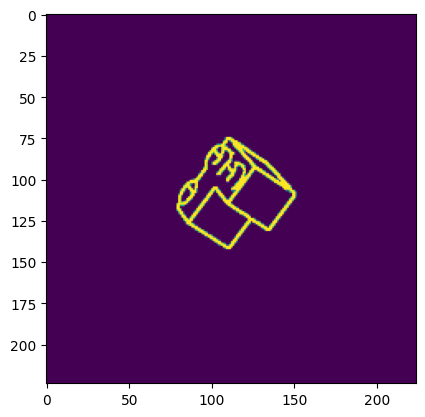

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Lego Brick ID 2357: 24.352%
Lego Brick ID 3010: 11.046%
Lego Brick ID 3001: 12.185%
Lego Brick ID 3022: 52.416%

Prediction Probabilities: [[0.24351977 0.11046495 0.12185401 0.5241613 ]]

Predicted Lego ID: 3022


In [ ]:
# Make predictions

img_id = 20

input_image = X_test_np[img_id]

plt.imshow(X_test_np[img_id])
plt.show()

# Add a batch dimension:
input_image = input_image[np.newaxis, ...]
prediction = model1.predict(input_image)
lego_class = np.argmax(prediction)   # Lego with high probability

for i, prob in enumerate(prediction[0]):
    percentage = prob * 100
    print(f"Lego Brick ID {lego_classes[i]}: {percentage:.3f}%")
print
#print(f"Test Brick ID: {unique_classes[100]}","Prediced Lego ID :", {unique_classes[predicted_class]})
print(f"\nPrediction Probabilities: {prediction}")
#print(f"Lego pieces list: {unique_classes}")
print(f"\nPredicted Lego ID: {lego_classes[lego_class]}")





In [ ]:
from google.colab import drive
import pickle

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model1.save('/content/drive/MyDrive/model1_trained.keras')  # Save model
#model = keras.models.load_model('/content/drive/MyDrive/model_checkpoint.keras')

In [ ]:
model1.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_75 (Conv2D)                   │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_72 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ (None, 112, 112, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_73 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ (None, 54, 54, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_74 (MaxPooling2D)      │ (None, 27, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 128)                 │      11,944,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,388,430 (138.81 MB)

 Trainable params: 12,129,476 (46.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,258,954 (92.54 MB)

# Model 2 - L1 Regularization

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras import initializers

model2 = keras.Sequential([

    #Layer 1
    layers.Conv2D(64, (3, 3), activation='relu',input_shape=(224, 224, 1)),
    layers.MaxPooling2D((2, 2)),

    #Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #Layer 3
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l1(0.01)),
    layers.MaxPooling2D((2, 2)),

    #Layer 4
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l1(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    #Layer 5
    layers.Dense(512, activation='relu',kernel_regularizer=keras.regularizers.l1(0.01)),

    #Layer 6
    layers.Dense(4, activation='softmax')
])

# Compile the model

model2.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])


# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=7,          # Number of epochs to wait for improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with the callback
history = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)
# Evaluate the model using the testing data
model2.evaluate(X_test_np, y_test_np)


Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.2613 - loss: 668.7812 - val_accuracy: 0.2627 - val_loss: 156.7194
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2573 - loss: 89.9078 - val_accuracy: 0.2623 - val_loss: 22.2609
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2570 - loss: 18.9592 - val_accuracy: 0.2623 - val_loss: 10.4858
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2533 - loss: 8.4696 - val_accuracy: 0.2623 - val_loss: 3.8496
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2561 - loss: 3.1185 - val_accuracy: 0.2623 - val_loss: 2.0419
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2549 - loss: 1.9977 - val_accuracy: 0.2623 - val_loss: 1.9785
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2577 - loss: 1.9776 - val_accuracy: 0.2623 - val_loss: 1.9770
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2528 - loss: 1.9776 -

[1.9785302877426147, 0.2226148396730423]

# Model2 - Evaluation

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2413 - loss: 1.9783 

Test Accuracy: 22.26%
Test Loss: 1.9785


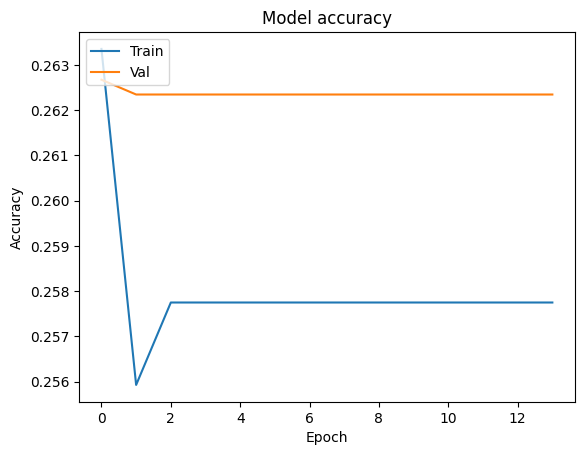

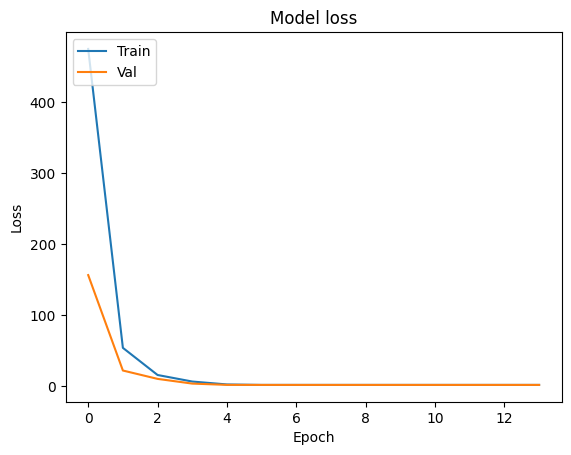

In [ ]:
# Evaluate the model using the testing data
test_results= model2.evaluate(X_test_np, y_test_np)
print(f"\nTest Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Loss: {test_results[0]:.4f}")


# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
model2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)                   │ (None, 222, 222, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,096,270 (110.99 MB)

 Trainable params: 9,698,756 (37.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,397,514 (74.00 MB)

# Model 4 - L2 Regularization

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras import initializers

model4 = keras.Sequential([

    #Layer 1
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(224, 224, 1)),
    layers.MaxPooling2D((2, 2)),


    #Layer 2
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.03)),
    layers.MaxPooling2D((2, 2)),

    #Layer 3
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.03)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    #Layer 4
    layers.Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),

    #Layer 5
    layers.Dense(4, activation='softmax')
])

# Compile the model

model4.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])


# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=5,          # Number of epochs to wait for improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with the callback
history = model4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)
# Evaluate the model using the testing data
model4.evaluate(X_test_np, y_test_np)


Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.2637 - loss: 6.3842 - val_accuracy: 0.2774 - val_loss: 4.3883
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3103 - loss: 3.9543 - val_accuracy: 0.3036 - val_loss: 2.9538
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3420 - loss: 2.7067 - val_accuracy: 0.3153 - val_loss: 2.1840
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3601 - loss: 2.0354 - val_accuracy: 0.3124 - val_loss: 1.7860
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3863 - loss: 1.6782 - val_accuracy: 0.3536 - val_loss: 1.5794
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4052 - loss: 1.4889 - val_accuracy: 0.3618 - val_loss: 1.4990
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4306 - loss: 1.3809 - val_accuracy: 0.3611 - val_loss: 1.4643
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4901 - loss: 1.2824 - val_acc

[1.7030351161956787, 0.2614840865135193]

## Model 4 - Evaluations

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2756 - loss: 1.7026 

Test Accuracy: 26.15%
Test Loss: 1.7030


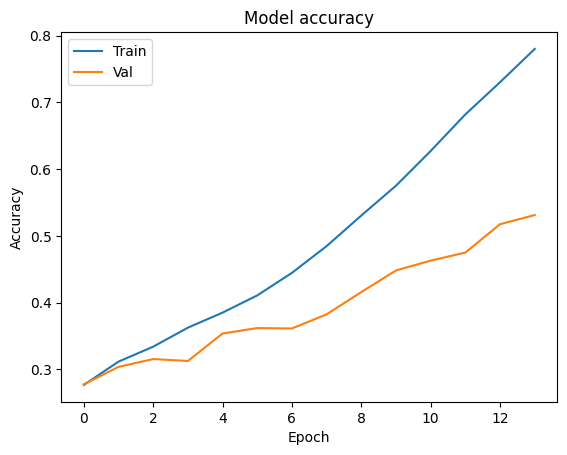

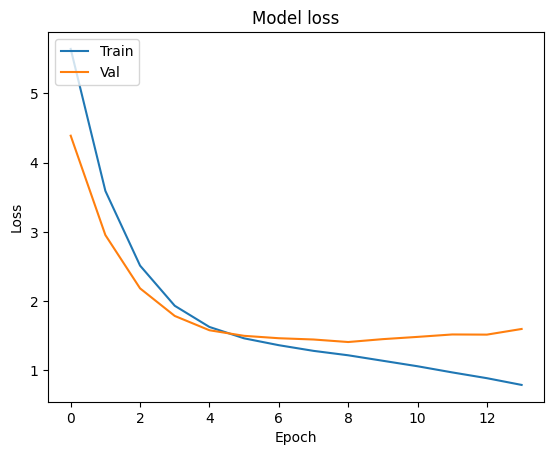

In [ ]:
# Evaluate the model using the testing data
test_results= model4.evaluate(X_test_np, y_test_np)
print(f"\nTest Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Loss: {test_results[0]:.4f}")


# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
model4.save('/content/drive/MyDrive/model4_trained.keras')

# Model3 - With dropouts

In [ ]:
# Define a basic CNN model

from tensorflow.keras.initializers import HeNormal

model3 = keras.Sequential([

    #Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    layers.MaxPooling2D((2, 2)),

    #Layer 2
    layers.Conv2D(128, (3, 3), activation='relu'),
    #layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),

    #Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    #layers.Dropout(0.1),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    #Layer 4
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),

    #Layer 5
    layers.Dense(4, activation='softmax')
])

# Compile the model

model3.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# Train the model with the callback
history = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model using the testing data
model3.evaluate(X_test_np, y_test_np)


Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.2808 - loss: 1.3843 - val_accuracy: 0.2787 - val_loss: 1.3773
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3180 - loss: 1.3607 - val_accuracy: 0.3261 - val_loss: 1.3623
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3804 - loss: 1.3167 - val_accuracy: 0.3386 - val_loss: 1.3488
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4345 - loss: 1.2525 - val_accuracy: 0.3746 - val_loss: 1.3242
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4835 - loss: 1.1828 - val_accuracy: 0.4001 - val_loss: 1.3139
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5427 - loss: 1.0754 - val_accuracy: 0.4341 - val_loss: 1.2766
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6229 - loss: 0.9471 - val_accuracy: 0.4652 - val_loss: 1.2644
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6687 - loss: 0.8376 - val_accu

[1.969582438468933, 0.2826855182647705]

# Model 3 Evaluations

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3266 - loss: 2.0129 

Test Accuracy: 28.27%
Test Loss: 1.9696


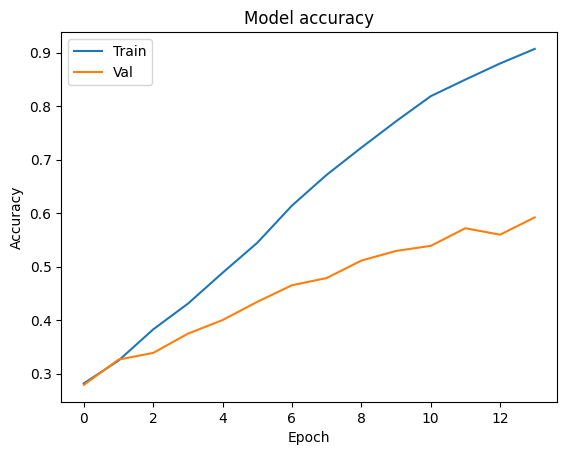

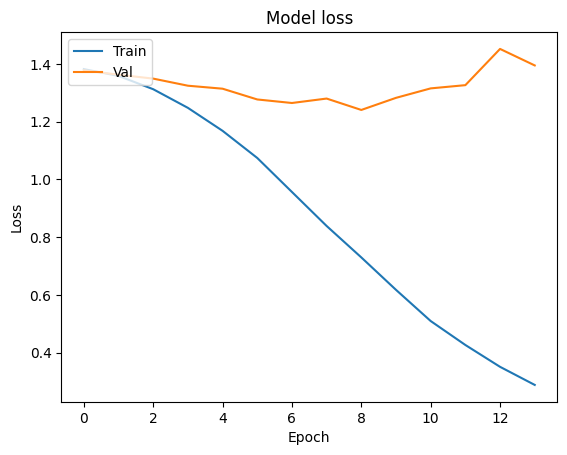

In [ ]:
# Evaluate the model using the testing data
test_results= model3.evaluate(X_test_np, y_test_np)
print(f"\nTest Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Loss: {test_results[0]:.4f}")

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
model3.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_71 (Conv2D)                   │ (None, 222, 222, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_68 (MaxPooling2D)      │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_69 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 52, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_70 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_71 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,096,270 (110.99 MB)

 Trainable params: 9,698,756 (37.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,397,514 (74.00 MB)

In [ ]:
model3.save('/content/drive/MyDrive/model3_trained.keras')

## Hyperparamter tuning - Random search

In [ ]:

!pip install keras-tuner -q

import keras
from keras import layers
from keras_tuner import HyperModel, RandomSearch
import tensorflow as tf

# Define a model using HyperModel (used for hyperparameter tuning)
class CNNHyperModel(HyperModel):
    def build(self, hp):
        # Create a Sequential model
        model3 = keras.Sequential()

        # Hyperparameters for Conv2D layers
        model3.add(layers.Conv2D(
            filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu',
            input_shape=(224, 224, 3)
        ))
        model3.add(layers.MaxPooling2D((2, 2)))

        model3.add(layers.Conv2D(
            filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model3.add(layers.MaxPooling2D((2, 2)))

        model3.add(layers.Conv2D(
            filters=hp.Int('conv_3_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model3.add(layers.Flatten())

        # Hyperparameter for Dense layer
        model3.add(layers.Dense(
            units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
            activation='relu'
        ))

        # Output layer
        model3.add(layers.Dense(4, activation='softmax'))  # Binary classification

        # Compile the model
        model3.compile(
            optimizer=keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model3


# Instantiate the HyperModel
cnn_hypermodel = CNNHyperModel()

# Define the hyperparameter search
tuner = RandomSearch(
    cnn_hypermodel,
    objective='val_accuracy',  # We aim to optimize validation accuracy
    max_trials=5,               # Number of different hyperparameter combinations to test
    executions_per_trial=3,     # How many times to train each model
    directory='tuner_dir',      # Directory to save the results
    project_name='cnn_batch_tuning'  # Project name
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=32)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test data
best_model.evaluate(X_test_np, y_test_np)





Trial 5 Complete [00h 10m 02s]
val_accuracy: 0.32159624497095746

Best val_accuracy So Far: 0.3262910743554433
Total elapsed time: 00h 52m 41s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.2171 - loss: 6.6949


[6.253284454345703, 0.23591549694538116]

In [ ]:

# Print best hyperparameters
print("Best Hyperparameters Found:")
for param in best_hyperparameters.values:  # Use best_hyperparameters instead of best_hps
    print(f"{param}: {best_hyperparameters.get(param)}")

Best Hyperparameters Found:
conv_1_filters: 32
conv_2_filters: 128
conv_3_filters: 128
dense_units: 128


#Gradio application code

In [ ]:
# Import Gradio
import gradio as gr
import pyttsx3



In [ ]:
#Initialize the TTS engine
engine=pyttsx3.init()

engine.setProperty('rate', 185)


#Funciton to convert text to speech
def text_to_speech(text):
    voices = engine.getProperty('voices')
    engine.setProperty('voice', voices[19].id)
    engine.save_to_file(text,"output.wav")
    engine.runAndWait()
    return "output.wav"

In [ ]:
from google.colab import files



# Upload files (prompts user to select file(s))
uploaded = files.upload()

Saving 3001.png to 3001.png


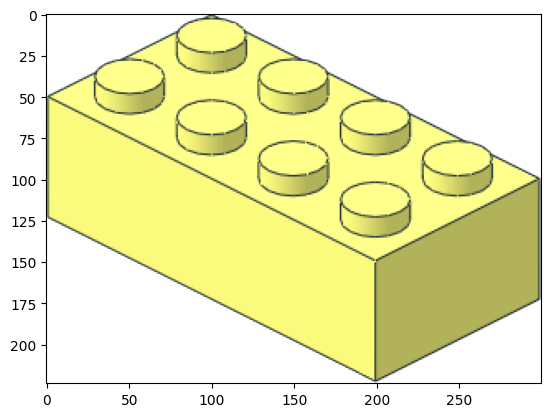

In [ ]:
from PIL import Image
import io
import matplotlib.pyplot as plt

for filename in uploaded.keys():
    input_image = Image.open(io.BytesIO(uploaded[filename]))

plt.imshow(input_image)
plt.show()



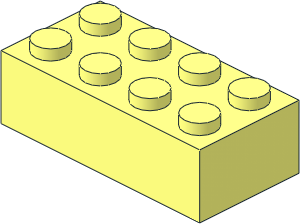

In [ ]:
input_image.resize((224,224))
input_image

## Gradio - Input image processing

In [ ]:
# process image function called from Gradio application

def process_image(img):

  kernel = np.ones((3, 3), np.uint8)

  array_input = np.array(input_image)
  edges_input=cv2.Canny(array_input,50,150)

  dilated_edges_input = cv2.dilate(edges_input, kernel, iterations=1)
  resized_image_input = cv2.resize(dilated_edges_input, (100, 100))

  # Add padding to make it 224x224
  top = bottom = (224 - 100) // 2
  left = right = (224 - 100) // 2
  padded_image = cv2.copyMakeBorder(resized_image_input, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

  expanded_edges_input = np.stack((padded_image,) * 1, axis=-1)
  #print("Expanded Input image Shape:", expanded_edges_input.shape)  # Check the shape

  #plt.figure(figsize=(10,6))
  #plt.imshow(expanded_edges_input, cmap="gray")
  #plt.title("Canny Edge Detection")
  #plt.axis("off")
  #plt.show()

  float_image_input = np.array(expanded_edges_input).astype(np.float32)
  #print(np.array(float_images[700]).min(), np.array(float_images[700]).max())
  normalized_image_input = float_image_input/255
  print(np.array(normalized_image_input).min(), np.array(normalized_image_input).max())
  normalized_image_input.shape
  normalized_image_input = np.expand_dims(normalized_image_input, axis=0)
  predict_input_image= model1.predict(normalized_image_input)
  predicted_class = np.argmax(predict_input_image)  # Get class index
  #print(predicted_class)

  # Add the lego record in dictionary
  probability_lines=[]
  probs = predict_input_image[0]
  probability_lines = [
        f"Lego Brick ID {lego_classes[i]}: {prob * 100:.2f}%"
        for i, prob in enumerate(probs)
    ]
  probabilities_text = "\n".join(probability_lines)

  info_text = f"The LEGO Brick is: {lego_classes[predicted_class]}"
  audio_path =text_to_speech(info_text)

  return probabilities_text, audio_path

  #for i, prob in enumerate(predict_input_image[0]):
  #  percentage = prob * 100
  #  print(f"Lego Brick ID {lego_classes[i]}: {percentage:.3f}%")


   #print(f"\nPrediction Probabilities: {predict_input_image}")

   #print(f"\nPredicted Lego ID: {lego_classes[predicted_class]}")


## Gradio old code - Ignore

In [ ]:
import cv2
import numpy as np

# Process the input image
def process_image_old(img):
  lego_classes = ['2357', '3001', '3022', '3010']

  numpy_image = np.array(img)  # Convert PIL Image to NumPy array

  #Convert image to grayscale
  grayscale_image_inp = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2GRAY)
  resized_image_inp = cv2.resize(grayscale_image_inp, (128, 128))  # Resize to desired dimensions

  #Edge detection and dilated edges

  kernel = np.ones((3, 3), np.uint8)

  new_image_inp = [np.array(img)  for img in resized_image_inp]
  edges_inp=[cv2.Canny(img,50,150) for img in new_image_inp]

  dilated_edges_inp = [cv2.dilate(img, kernel, iterations=1) for img in edges_inp]
  expanded_edges_inp = [np.stack((img,) * 3, axis=-1) for img in dilated_edges_inp]
  batched_images_inp = np.array(expanded_edges_inp)
  print("Batched Images Shape:", batched_images_inp.shape)  # Check the shape


  plt.figure(figsize=(8,6))
  plt.imshow(batched_images_inp[0], cmap="gray")
  plt.title("Canny Edge Detection")
  plt.axis("off")
  plt.show()

  #Pre-process the image
  float_image = np.array(batched_images_inp).astype(np.float32)
  normalized_image = float_image / 255.0


  #Add channel and batch dimensions
  #image_with_channel = np.expand_dims(normalized_image, axis=0)
  image_with_channel1 = np.expand_dims(normalized_image, axis=-1)

  processed_input = np.expand_dims(image_with_channel1, axis=0)

  #Predict the image through model
  predict_image= model3.predict(processed_input)
  predicted_class = np.argmax(predict_image)  # Get class index
  print(predicted_class)

  # Add the lego record in dictionary
  probability_lines=[]
  #probs = predict_image[0]
  probability_lines = [
        f"Lego Brick ID {lego_classes[i]}: {prob * 100:.2f}%"
        for i, prob in enumerate(probs)
    ]
  probabilities_text = "\n".join(probability_lines)

  info_text = f"The Predicted LEGO Brick is: {lego_classes[predicted_class]}"
  audio_path =text_to_speech(info_text)

  return probabilities_text, audio_path


## Gradio app Interface and Launch

In [ ]:
#image_path = "C:/Users/Owner/Git_Local/project3_prep/Demo_images/300121.jpg"
app = gr.Interface(


    fn=process_image,  # Function to call
    inputs=gr.Image(type="pil"),  # Input type (image)
    outputs=[
              gr.Textbox(label="Lego probability"),
              gr.Audio(label="Generated speech",type="filepath"),
              ],
    submit_btn="Predict Lego Brick",
    title="LEGO Type Classifier",
    description="Upload an image of a LEGO brick to classify its type.",
    #css=css_code
)

app.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6f9e0e6a68c0263dd1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


0.0 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2137, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1663, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://6f9e0e6a68c0263dd1.gradio.live
